In [8]:
# scikit-learn playground 

In [9]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


df = pd.read_csv('data/chr20_out.tsv', sep='\t', encoding = "UTF-8")
df = df.set_index(['chr','pos', 'ref', 'alt']) #index by identifier
#print(df.to_string()) ## will print the whole dataframe
#df.plot.hist()

print("shape before", df.shape)
df['FATHMM_score'] = df['FATHMM_score'].replace({'.': np.nan})
df['MetaSVM_score'] = df['MetaSVM_score'].replace({'.': np.nan})  # find a generalized way to replace
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
df.head()

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

df.head()
df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

df= df.drop(columns=['clinvar_clnsig', 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

print("shape after dropping Unk", df.shape)
#df.head()

shape before (3337, 4)
shape after dropping all data with score = '.' (1900, 4)
shape after dropping Unk (633, 3)


In [10]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                     FATHMM_score MetaSVM_score  Problematic
chr pos      ref alt                                        
20  5302452  C   T           1.08       -1.0156            1
    63419667 C   A          -5.29        0.6922            0
    45898107 A   G           -3.1        1.0038            1

Test data subset

                    FATHMM_score MetaSVM_score  Problematic
chr pos     ref alt                                        
20  968019  C   G          -2.06        0.5258            1
    1980372 C   T          -2.13        0.4429            0
    1980513 T   A           -1.6       -0.5999            0


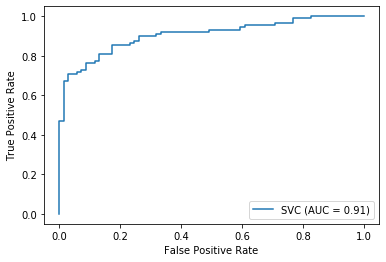

y true [1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1
 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 0 0 1 0]
y predicted [1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1
 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0
 1 1 1 0 0 0 0 0 0 0]
Confusion matrix: 
 [[58 11]
 [17 72]]
Accuracy: 0.8227848101265823
Recall TP/(TP+FN): [0.84057971 0.80898876]
Precision TP/(TP+FP): [0.77333333 0.86746988]
F1: [0.80555556 0.8372093 ]


In [11]:
## Try a binary support vector machine:

classifier1 = SVC(kernel='rbf', gamma='scale',random_state=42) # default for kernel and gamma. AUC = 0.94
classifier2 = SVC(kernel='linear', gamma=10 ,random_state=42) # 0.94
classifier3 = SVC(kernel='sigmoid', gamma=10 ,random_state=42) # 0.82

classifier1.fit(df_train, train_labels)
svc_disp = plot_roc_curve(classifier1, df_test, test_labels)
plt.show()


### Run some stats to see if the model is doing well. 
### Note: for chr20, there are 696 exampels that pass, meaning 25% used for testing gives low numbers, see cm
y_true = test_labels.to_numpy()
y_pred = classifier1.predict(df_test)


print("y true", y_true) ## These are both numpy arrays now, why are the metrics returning arrays rather than single f
print("y predicted", y_pred)

## see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

In [12]:
#type(y_true.to_numpy())  # pandas.core.series.Series
#type(y_pred) # numpy.ndarray

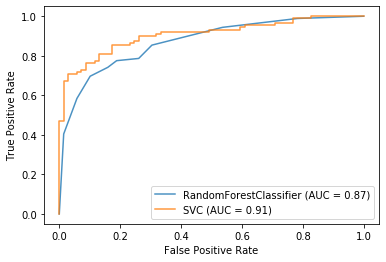

Feature ranking:
1. feature 1 (0.610717)
2. feature 0 (0.389283)


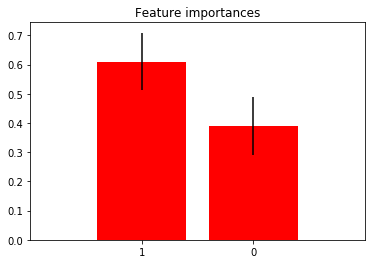

In [13]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), indices)
plt.xlim([-1, df_train.shape[1]])
plt.show()